In [16]:
#!/usr/bin/env python
# coding: utf-8
import sys
sys.path.append('..')
import umbrella_mesh
import elastic_rods
import linkage_vis
from umbrella_mesh import UmbrellaEnergyType
from bending_validation import suppress_stdout as so
from visualization_helper import *

import pipeline_helper, importlib, design_optimization_analysis
with so(): importlib.reload(pipeline_helper)
with so(): importlib.reload(design_optimization_analysis)

from pipeline_helper import UmbrellaOptimizationCallback, allEnergies, allGradientNorms, allDesignObjectives, allDesignGradientNorms, set_joint_vector_field, show_center_joint_normal, show_joint_normal

from design_optimization_analysis import DesignOptimizationAnalysis

import umbrella_optimization
import umbrella_optimization_finite_diff
from umbrella_optimization import OptEnergyType

import numpy as np
import numpy.linalg as la

import pickle, gzip

from configuration import *


import parallelism
parallelism.set_max_num_tbb_threads(24)
parallelism.set_hessian_assembly_num_threads(8)
parallelism.set_gradient_assembly_num_threads(8)

### Initialization

In [17]:
name = 'lilium_smooth'
input_path = '../../data/{}.json.gz'.format(name)

handleBoundary = False
io, input_data, target_mesh, curr_um, thickness, target_height_multiplier = parse_input(input_path, handleBoundary = handleBoundary)
# target_height_multiplier = 1

# curr_um = pickle.load(gzip.open('../../data/optim/lilium_smooth_optimized_equilibrium_2022_01_23_17_46_target_height_factor_5.0.pkl.gz', 'r'))

#### Pin Rigid Motion

In [18]:
use_pin = False

driver = curr_um.centralJoint()
jdo = curr_um.dofOffsetForJoint(driver)
fixedVars = (list(range(jdo, jdo + 6)) if use_pin else []) + curr_um.rigidJointAngleDoFIndices()

In [19]:
import py_newton_optimizer
OPTS = py_newton_optimizer.NewtonOptimizerOptions()
OPTS.gradTol = 1e-8
OPTS.verbose = 1
OPTS.beta = 1e-6
OPTS.niter = 300
OPTS.verboseNonPosDef = False

rod_colors = get_color_field(curr_um, input_data)

# lview = linkage_vis.LinkageViewer(curr_um, width=1024, height=600)
# lview.update(scalarField = rod_colors)
# lview.show()

import mesh
view = linkage_vis.LinkageViewerWithSurface(curr_um, target_mesh, width=1024, height=600)
set_surface_view_options(view, color = 'green', surface_color = 'gray', umbrella_transparent = False, surface_transparent = True)
view.averagedMaterialFrames = True
view.showScalarField(rod_colors)
view.show()

Renderer(camera=PerspectiveCamera(aspect=1.7066666666666668, children=(PointLight(color='#999999', position=(0…

In [20]:
view.getCameraParams()

view.getSize()

(1024, 600)

In [21]:
from equilibrium_solve_analysis import EquilibriumSolveAnalysis
eqays = EquilibriumSolveAnalysis(curr_um)
def eqm_callback(prob, i):
    eqays.record(prob)
    if (i % 2 == 0):
        view.showScalarField(rod_colors)

configure_umbrella_pre_deployment(curr_um, thickness, target_height_multiplier)


allGradientNorms(curr_um)

{'Full': 0.0018318343135694658,
 'Elastic': 3.4008875031412053e-12,
 'Deployment': 0.0,
 'Repulsion': 0.0,
 'Attraction': 0.0018315073978438388,
 'AngleBoundPenalty': 3.460641549785247e-05}

In [22]:
break_input_angle_symmetry(curr_um)

view.showScalarField(rod_colors)

results = staged_deployment(curr_um, np.logspace(-3, 0, 4), eqm_callback, OPTS, fixedVars)

results.success

True

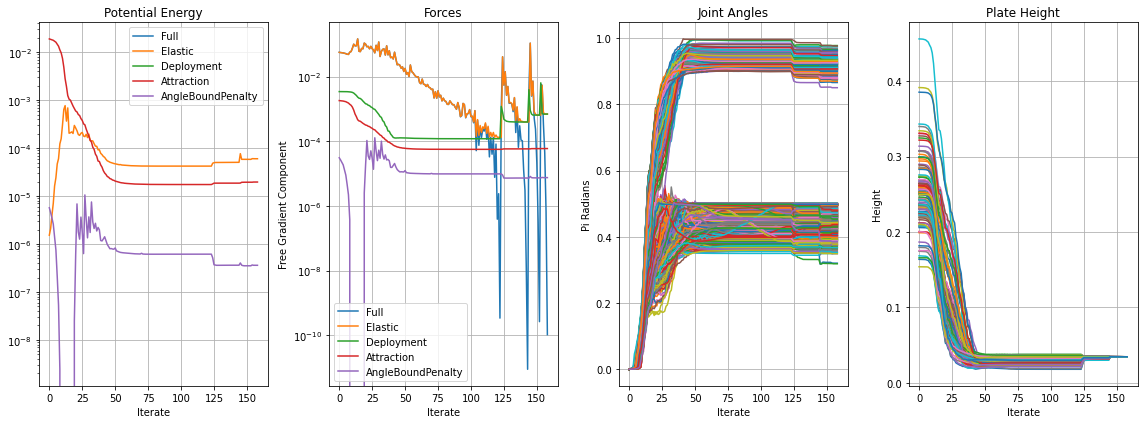

In [23]:
eqays.plot()

In [24]:
# use_pin = True

# driver = curr_um.centralJoint()
# jdo = curr_um.dofOffsetForJoint(driver)
# fixedVars = (list(range(jdo, jdo + 6)) if use_pin else []) + curr_um.rigidJointAngleDoFIndices()

# configure_umbrella_true_equlibrium(curr_um, thickness, target_height_multiplier)

# allEnergies(curr_um)

# OPTS.niter = 100

# results = umbrella_mesh.compute_equilibrium(curr_um, callback = eqm_callback, options = OPTS, fixedVars = fixedVars, elasticEnergyIncreaseFactorLimit=2.5)

# results.success

In [25]:
# import registration
# R, t = registration.register_points(curr_um.XJointPositions().reshape(-1,3), curr_um.XJointTgtPositions().reshape(-1,3))
# V = target_mesh.vertices()
# V_reg = R @ V.transpose() + np.repeat(t[:, np.newaxis],  len(V), axis = 1)
# target_mesh_reg = mesh.Mesh(V_reg.transpose(), target_mesh.elements())
# view2 = linkage_vis.LinkageViewerWithSurface(curr_um, target_mesh_reg, width=1024, height=600)
# set_surface_view_options(view2, color = 'green', surface_color = 'gray', umbrella_transparent = False, surface_transparent = True)
# view2.averagedMaterialFrames = True
# view2.showScalarField(rod_colors)
# view2.show()

In [26]:
# use_pin = False

# driver = curr_um.centralJoint()
# jdo = curr_um.dofOffsetForJoint(driver)
# fixedVars = (list(range(jdo, jdo + 6)) if use_pin else []) + curr_um.rigidJointAngleDoFIndices()

### Initialize Design Optimization

In [27]:
configure_umbrella_optimization(curr_um)
# curr_um.scaleInputPosWeights(0.1, bdryMultiplier = 1.5)

import py_newton_optimizer
opt_opts = py_newton_optimizer.NewtonOptimizerOptions()
opt_opts.gradTol = 1e-8
opt_opts.verbose = 10
opt_opts.beta = 1e-6
opt_opts.niter = 600
opt_opts.verboseNonPosDef = False

results = umbrella_mesh.compute_equilibrium(curr_um, callback = eqm_callback, options = opt_opts, fixedVars = fixedVars, elasticEnergyIncreaseFactorLimit=2.5)

opt_opts.niter = 50

results.success

# import force_analysis
# force_analysis.UmbrellaForceAnalysis(curr_um)
# v2 = force_analysis.UmbrellaForceFieldVisualization(curr_um)
# v2.show()

0	-121	5.97646e-05	5.97646e-05	1	1
10	-121	0.00901383	0.00901383	0.5	0
20	-121	0.00323194	0.00323194	0.25	0
30	-121	0.00193085	0.00193085	1	0
40	-121	0.000217964	0.000217964	1	0


True

In [28]:
optimizer = umbrella_optimization.UmbrellaOptimization(curr_um, opt_opts, 2.5, -1, False, fixedVars)

optimizer.beta = 1 * 1e6
optimizer.gamma = 1e1
optimizer.eta = 0
optimizer.zeta = 0# 1e1
optimizer.iota = 0

rest_height_optimizer = umbrella_optimization.UmbrellaRestHeightsOptimization(optimizer)
single_rest_height_optimizer = umbrella_optimization.UmbrellaSingleRestHeightOptimization(rest_height_optimizer)

rest_height_optimizer.newPt(rest_height_optimizer.params())

original_design_parameters = rest_height_optimizer.params()

doptays = DesignOptimizationAnalysis(rest_height_optimizer)
def eqm_callback(prob, i):
    eqays.record(prob)
    if (i % 2 == 0):
        view.showScalarField(rod_colors)

import time
pipeline_helper.prev_time_stamp = time.time()

uo = rest_height_optimizer.get_parent_opt()

uo.equilibriumOptimizer.options.verbose = 1
#uo.equilibriumOptimizer.options.verboseWorkingSet = True
uo.equilibriumOptimizer.options.gradTol = 1e-10
# Hold the closest points fixed in the target-attraction term of the equilibrium solve:
# this seems to make the design optimization much more robust.
uo.setHoldClosestPointsFixed(True, False)

In [29]:
tfview = pipeline_helper.TargetFittingVisualization(curr_um, uo.target_surface_fitter, view)
cb = pipeline_helper.UmbrellaOptimizationCallback(rest_height_optimizer, view, True, False, 1, rod_colors, doptays.record, tfview=tfview)

In [30]:
algorithm = umbrella_optimization.OptAlgorithm.NEWTON_CG
#algorithm = umbrella_optimization.OptAlgorithm.BFGS
solverStatus = umbrella_optimization.optimize(rest_height_optimizer, algorithm, 50, 0.005, 1e-5, cb, input_data["plate_edge_length"] / 30 * 32)

In [31]:
rest_height_optimizer.reset_joint_target_with_closest_points()
# curr_um.scaleInputPosWeights(0.1, bdryMultiplier = 1.0)

algorithm = umbrella_optimization.OptAlgorithm.NEWTON_CG
#algorithm = umbrella_optimization.OptAlgorithm.BFGS
solverStatus = umbrella_optimization.optimize(rest_height_optimizer, algorithm, 1000, 0.005, 1e-5, cb, input_data["plate_edge_length"] / 30 * 32)

In [18]:
# rest_height_optimizer.reset_joint_target_with_closest_points()
# # curr_um.scaleInputPosWeights(0.1, bdryMultiplier = 1.0)

# algorithm = umbrella_optimization.OptAlgorithm.NEWTON_CG
# #algorithm = umbrella_optimization.OptAlgorithm.BFGS
# solverStatus = umbrella_optimization.optimize(rest_height_optimizer, algorithm, 1000, 0.005, 1e-5, cb, input_data["plate_edge_length"] / 30 * 32)

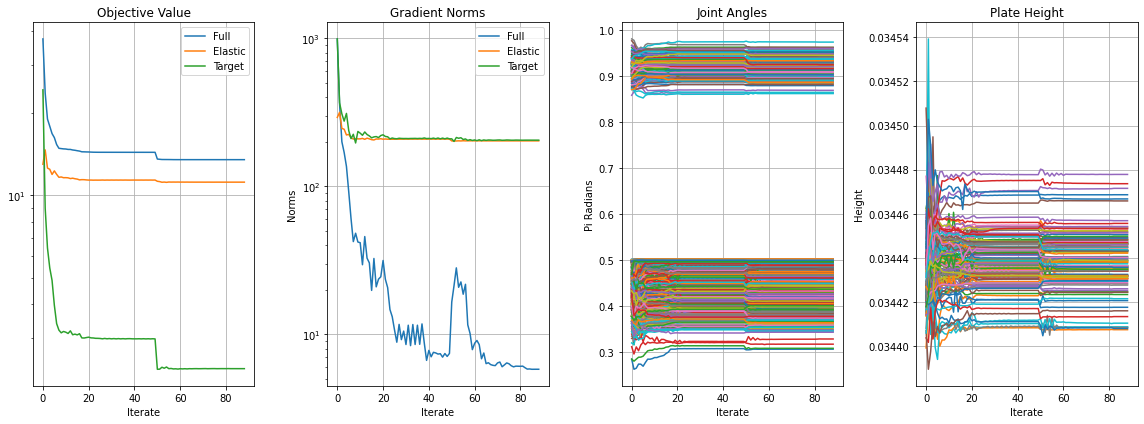

In [32]:
import time

from matplotlib import pyplot as plt
doptays.plot()

In [33]:
rest_height_optimizer.beta = 1 * 1e7
curr_um.scaleInputPosWeights(0.1, bdryMultiplier = 1.0)

algorithm = umbrella_optimization.OptAlgorithm.NEWTON_CG
solverStatus = umbrella_optimization.optimize(rest_height_optimizer, algorithm, 10000, 0.005, 1e-5, cb, input_data["plate_edge_length"] / 30 * 32)

In [34]:
rest_height_optimizer.beta, rest_height_optimizer.gamma, rest_height_optimizer.eta

(10000000.0, 10.0, 0.0)

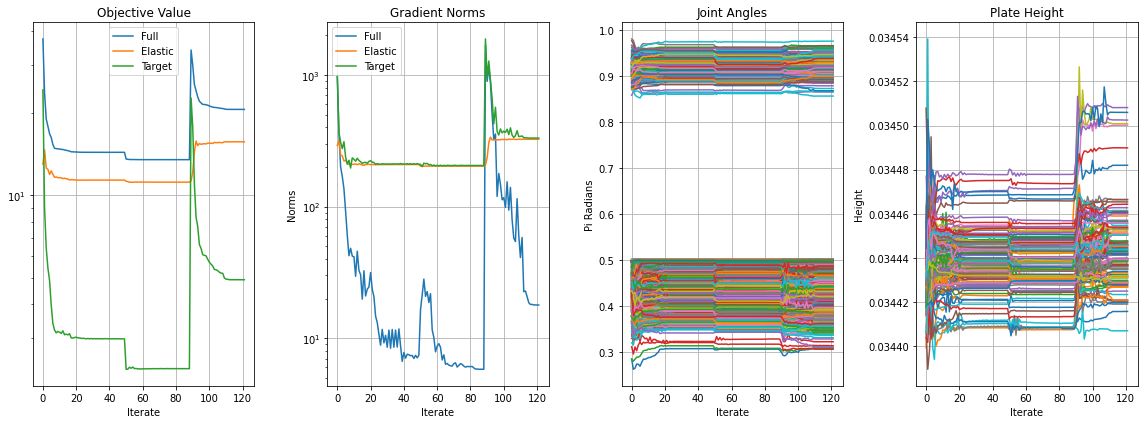

In [36]:
import time

from matplotlib import pyplot as plt
doptays.plot()

### Get true equilibrium state

In [37]:
use_pin = True

driver = curr_um.centralJoint()
jdo = curr_um.dofOffsetForJoint(driver)
fixedVars = (list(range(jdo, jdo + 6)) if use_pin else []) + curr_um.rigidJointAngleDoFIndices()

configure_umbrella_true_equlibrium(curr_um, thickness, target_height_multiplier)

allEnergies(curr_um)

OPTS.niter = 100

results = umbrella_mesh.compute_equilibrium(curr_um, callback = eqm_callback, options = OPTS, fixedVars = fixedVars, elasticEnergyIncreaseFactorLimit=2.5)

results.success

0	-121	2.46634e-07	2.46634e-07	0.5	0
1	-121	0.000609242	0.000609242	1	0
2	-121	3.08132e-05	3.08132e-05	1	0
3	-121	0.000165338	0.000165338	1	0
4	-121	1.31858e-06	1.31858e-06	1	0
5	-121	8.1758e-05	8.1758e-05	1	0
6	-121	1.35223e-08	1.35223e-08	1	0
7	-121	6.91757e-07	6.91757e-07	1	0
8	-121	8.61251e-12	8.61251e-12	1	0


True

In [38]:
# import force_analysis
# force_analysis.UmbrellaForceAnalysis(curr_um)
# v2 = force_analysis.UmbrellaForceFieldVisualization(curr_um)
# v2.show()

In [39]:
# assert 0
import pickle 
import gzip

pickle.dump(curr_um, gzip.open('../../data/optim/{}_optimized_equilibrium_{}_target_height_factor_{}.pkl.gz'.format(name, time.strftime("%Y_%m_%d_%H_%M"), target_height_multiplier), 'w'))
# load_um = pickle.load(gzip.open('test_pickle_um.pkl.gz', 'r'))

from load_jsondata import update_optimized_json
update_optimized_json(input_path, rest_height_optimizer.params(), output_json_path = '../../data/optim/{}_optimized_params_{}.json'.format(name, time.strftime("%Y_%m_%d_%H_%M")), optim_spacing_factor = target_height_multiplier)



In [40]:

from load_jsondata import write_deformed_config
output_path = '../../data/optim/{}_optimized_rendering_output_{}.json.gz'.format(name, time.strftime("%Y_%m_%d_%H_%M"))
write_deformed_config(curr_um, input_path, output_path, write_stress = False, is_rest_state = False, handleBoundary = handleBoundary)

### Undeployment

In [41]:
configure_umbrella_undeployment_step_one(curr_um, thickness, target_height_multiplier)

In [42]:
allEnergies(curr_um)

{'Full': -115.1905585173697,
 'Elastic': 7.052990668777835e-05,
 'Deployment': -115.1906300673769,
 'Repulsion': 0.0,
 'Attraction': 0.0,
 'AngleBoundPenalty': 1.0201005159210048e-06}

In [43]:
OPTS.niter = 10

In [48]:
results = umbrella_mesh.compute_equilibrium(curr_um, callback = eqm_callback, options = OPTS, fixedVars = fixedVars, elasticEnergyIncreaseFactorLimit=2.5)
results.success

0	-120.227	0.0775554	0.0775554	1	1
1	-120.254	0.216395	0.216395	1	1
2	-120.256	0.052156	0.052156	1	1
3	-120.258	0.0342614	0.0342614	1	1
4	-120.261	0.0333582	0.0333582	1	1
5	-120.268	0.0381827	0.0381827	1	1
6	-120.28	0.0839324	0.0839324	0.25	1
7	-120.281	0.197178	0.197178	1	1
8	-120.286	0.0630307	0.0630307	1	1
9	-120.287	0.0382947	0.0382947	1	1
10	-120.288	0.033455	0.033455	1	1


False

In [49]:
configure_umbrella_undeployment_step_two(curr_um)

In [50]:
allEnergies(curr_um)

{'Full': 0.42221558584379404,
 'Elastic': 0.4215117551960264,
 'Deployment': 0.0,
 'Repulsion': 0.0,
 'Attraction': 0.0,
 'AngleBoundPenalty': 0.0007038306477676481}

In [51]:
OPTS.niter = 500

In [52]:
results = umbrella_mesh.compute_equilibrium(curr_um, callback = eqm_callback, options = OPTS, fixedVars = fixedVars, elasticEnergyIncreaseFactorLimit=2.5)
results.success

0	0.422216	1.07686	1.07686	1	1
1	0.106798	2.99457	2.99457	1	1
2	0.071731	0.454058	0.454058	1	1
3	0.0653102	0.146463	0.146463	1	1
4	0.0606454	0.099897	0.099897	1	1
5	0.0551871	0.100006	0.100006	1	1
6	0.0481846	0.0995032	0.0995032	1	1
7	0.0391409	0.0887925	0.0887925	1	1
8	0.0287066	0.0958269	0.0958269	1	1
9	0.0189536	0.138842	0.138842	1	1
10	0.0118978	0.198033	0.198033	1	1
11	0.007849	0.226104	0.226104	1	1
12	0.0057454	0.223525	0.223525	1	1
13	0.00452478	0.195633	0.195633	1	1
14	0.00370473	0.173209	0.173209	1	1
15	0.00308661	0.149177	0.149177	1	1
16	0.00288967	0.0165851	0.0165851	1	1
17	0.00276382	0.0516793	0.0516793	1	1
18	0.00259256	0.0444109	0.0444109	1	1
19	0.00237776	0.0824718	0.0824718	1	1
20	0.00213123	0.0600072	0.0600072	1	1
21	0.00203583	0.254735	0.254735	0.25	1
22	0.00196413	0.19172	0.19172	1	1
23	0.00182546	0.0125307	0.0125307	1	1
24	0.00179553	0.00776586	0.00776586	1	1
25	0.00176004	0.0175765	0.0175765	1	1
26	0.00173594	0.00705236	0.00705236	1	1
27	0.00170201	0.0137558	0.0137

True

In [53]:
import pickle 
import gzip

pickle.dump(curr_um, gzip.open('../../data/optim/{}_optimized_rest_state_{}_target_height_factor_{}.pkl.gz'.format(name, time.strftime("%Y_%m_%d_%H_%M"), target_height_multiplier), 'w'))
write_deformed_config(curr_um, output_path, output_path, write_stress = False, is_rest_state = True, handleBoundary = handleBoundary)